In [1]:
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
#from IPython.display import clear_output

In [2]:
def add_noise(x):
    return x + torch.randn_like(x) * 0.1

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 596kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.49MB/s]


Text(0.5, 1.0, 'Image label: 4')

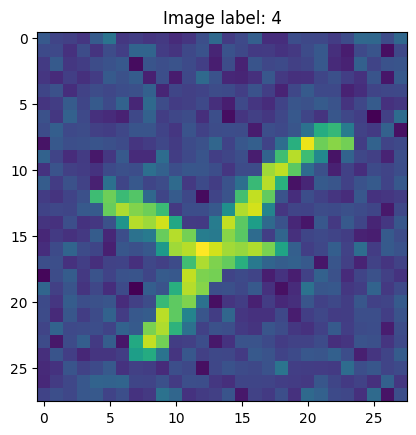

In [3]:
transform = transforms.Compose([
      transforms.RandomRotation(degrees=(-20, 20)),
      transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Сдвиги и масштабирование
      transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
      transforms.ToTensor(),
      add_noise,
      transforms.Normalize((0.1307,), (0.3081,))
])


train_mnist_data = datasets.MNIST('.', train=True, transform=transform, download=True)
# Тестовый датасет без аугментации, только ToTensor
test_mnist_data = datasets.MNIST('.', train=False, transform=transforms.ToTensor(), download=True)

train_data_loader = torch.utils.data.DataLoader(
      train_mnist_data,
      batch_size=32,
      shuffle=True,
      num_workers=2
  )

test_data_loader = torch.utils.data.DataLoader(
      test_mnist_data,
      batch_size=32,
      shuffle=False,
      num_workers=2
  )

example_data = next(iter(train_data_loader))
image, label = example_data[0][0], example_data[1][0]

image = image.permute(1, 2, 0)
image = image.numpy()


random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')


In [4]:
class NetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),  # 1 канал (ч/б), 32 фильтра
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(64 * 5 * 5, 128),  # Размер после пулинга: [64, 5, 5]
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Развертка в вектор
        return self.linear_layers(x)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NetCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [6]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_data_loader.dataset)} '
                  f'({100. * batch_idx / len(train_data_loader):.0f}%)]\tLoss: {loss.item():.6f}')

In [7]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_data_loader)
    accuracy = 100. * correct / len(test_data_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_data_loader.dataset)} '
          f'({accuracy:.2f}%)\n')
    return accuracy


In [ ]:
epochs = 5
best_accuracy = 0
for epoch in range(1, epochs + 1):
    train(epoch)
    current_accuracy = test()
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        torch.save(model.state_dict(), "best_mnist_cnn.pth")

print(f"Лучшая точность: {best_accuracy:.2f}%")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.338260
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.531370
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.385049
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.486167
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.261016
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.287978
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.197639
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.138112
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.522912
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.062889
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.259174
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.162464
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.369040
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.202630
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.352554
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.246233
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.148448
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.331046
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.225394

Test set: Average loss: 0.3139, Accuracy: 9795/10000 (97.9

In [ ]:
from google.colab import files
torch.save(model.state_dict(), "mnist_cnn.pth")
files.download('mnist_cnn.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>